### Import libraries

In [127]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import KBinsDiscretizer
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler


### Read the datasets

In [128]:
businessdata = pd.read_csv('business.csv')
businessdata['business'] = 1
economy = pd.read_csv('economy.csv')
economy['business'] = 0
dataset = pd.concat([businessdata,economy])

# Data Preparation

#### Rename Columns

In [129]:
dataset.rename(columns= {'date':'date_travel','ch_code':'character_code', 'num_code':'numerical_code', 'dep_time':'departure_time', 
'from':'source_city', 'time_taken':'duration_flight', 'stop':'stops', 'arr_time':'arrival_time', 'to':'destination_city'},inplace = True)

In [130]:
dataset.head()

,date_travel,airline,character_code,numerical_code,departure_time,source_city,duration_flight,stops,arrival_time,destination_city,price,business
0,11-02-2022,Air India,AI,868,18:00,Delhi,02h 00m,non-stop,20:00,Mumbai,"25,612",1
1,11-02-2022,Air India,AI,624,19:00,Delhi,02h 15m,non-stop,21:15,Mumbai,"25,612",1
2,11-02-2022,Air India,AI,531,20:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45,Mumbai,"42,220",1
3,11-02-2022,Air India,AI,839,21:25,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"44,450",1
4,11-02-2022,Air India,AI,544,17:15,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55,Mumbai,"46,690",1


In [131]:
dataset.count()

date_travel         300261
airline             300261
character_code      300261
numerical_code      300261
departure_time      300261
source_city         300261
duration_flight     300261
stops               300261
arrival_time        300261
destination_city    300261
price               300261
business            300261
dtype: int64

#### Dataset Size Reduction and Duplicates Removing

In [132]:


# duplicate row filtering
print("len before: " + str(len(dataset)))
dataset.drop_duplicates(inplace=True)
print("len after: " + str(len(dataset)))

len before: 300261
len after: 300259


### Stratified Sampling

In [133]:
dataset.groupby('price', group_keys=False).apply(lambda x: x.sample(frac=0.9))

,date_travel,airline,character_code,numerical_code,departure_time,source_city,duration_flight,stops,arrival_time,destination_city,price,business
54706,13-02-2022,Vistara,UK,776,17:35,Kolkata,23h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,16:55,Delhi,"1,00,111",1
35213,17-02-2022,Vistara,UK,910,17:35,Mumbai,16h 20m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,09:55,Chennai,"1,00,204",1
23826,17-02-2022,Vistara,UK,902,15:45,Mumbai,16h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,08:40,Bangalore,"1,00,276",1
23491,13-02-2022,Vistara,UK,988,20:55,Mumbai,20h 05m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:00,Bangalore,"1,00,276",1
15305,13-02-2022,Vistara,UK,809,19:50,Delhi,16h 00m,2+-stop,11:50,Chennai,"1,00,288",1
...,...,...,...,...,...,...,...,...,...,...,...,...
16226,27-02-2022,Vistara,UK,705,07:30,Delhi,12h 25m,2+-stop,19:55,Chennai,"99,577",1
83778,13-02-2022,Vistara,UK,838,21:05,Chennai,20h 35m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:40,Mumbai,"99,584",1
83777,13-02-2022,Vistara,UK,836,10:45,Chennai,06h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:40,Mumbai,"99,584",1
31461,13-02-2022,Vistara,UK,996,18:30,Mumbai,15h 10m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,09:40,Hyderabad,"99,677",1


#### Type conversion: Change cells from 'stop' column to an ordinal value 


In [134]:
stopValues = dataset.groupby(['stops'])['stops'].count()
print(stopValues)

stops
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\t                      243601
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia BBI\n\t\t\t\t\t\t\t\t\t\t\t\t                  158
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Bhubaneswar\n\t\t\t\t\t\t\t\t\t\t\t\t          301
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai\n\t\t\t\t\t\t\t\t\t\t\t\t               77
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Delhi\n\t\t\t\t\t\t\t\t\t\t\t\t                153
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAU\n\t\t\t\t\t\t\t\t\t\t\t\t                    3
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAY\n\t\t\t\t\t\t\t\t\t\t\t\t                    3
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GOP\n\t\t\t\t\t\t\t\t\t\t\t\t                   16
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati\n\t\t\t\t\t\t\t\t\t\t\t\t              55
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia HYD\n\t\t\t\t\t\t\t\t\t\t\t\t                    1
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad\n\t\t\t\t\t\t\t\t\t\t\t\t            143
1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia I

**As seen above, some of the cells in the "stop" column have a misformatting error (with multiple '\n' and '\t')**

In [135]:
dataset['stops'] = dataset['stops'].str.replace('\n', '')
dataset['stops'] = dataset['stops'].str.replace('\t', '')

# dataset.to_csv('stopvalues.csv')

**Now, let's convert to numeric type the number of stops**

In [136]:
dataset['stops'] = dataset['stops'].str.replace(r'1(.)+',  '1', regex=True)
dataset['stops'] = dataset['stops'].str.replace(r'no(.)+', '0', regex=True)
dataset['stops'] = dataset['stops'].str.replace(r'2(.)+',  '2',regex=True)

dataset['stops'] = dataset['stops'].apply(int)

#### Price to int

In [138]:

priceValues = dataset.groupby(['price'])['price'].count()
print(priceValues)


dataset['price'] = dataset['price'].str.replace(',', '')
dataset['price'] = dataset['price'].apply(int)




price
1,00,111    1
1,00,204    1
1,00,276    2
1,00,288    2
1,00,395    1
           ..
99,551      1
99,577      1
99,584      2
99,677      1
99,680      1
Name: price, Length: 12165, dtype: int64


#### Preço do bilhete ao fim de semana e à semana

In [139]:
dataset['date_travel'] = pd.to_datetime(dataset['date_travel'], format="%d-%m-%Y")

dw_mapping={
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0,
    5: 1, 
    6: 1
} 
dataset['weekend']=dataset['date_travel'].dt.weekday.map(dw_mapping)



#### duration_flight to int

In [137]:
def to_minutes(time_string):
    result = re.search(r'(\d+)h.*?(\d+)m', time_string)
    if (result):
       minutes = int(result.group(1)) * 60 + int(result.group(2))
       return minutes
    else: 
        return -1

dataset['duration_flight'] =  dataset['duration_flight'].apply(to_minutes)
# remover linhas que nao seja possivel converter para int
dataset = dataset[dataset.duration_flight != -1]



### Tratamento à data

In [140]:
dataset['year'] = dataset['date_travel'].dt.year
dataset['month'] = dataset['date_travel'].dt.month
dataset['day'] = dataset['date_travel'].dt.day

dataset = dataset.drop(['date_travel'], axis=1)

### Tratamento Departure Time and Arrival Time

In [141]:
def separate_hour(time):
    res = re.search(r'(\d+):(\d+)', time)
    if res:
        return int(res.group(1))

def separate_min(time):
    res = re.search(r'(\d+):(\d+)', time)
    if res:
        return int(res.group(2))



dataset['departure_hour'] = dataset['departure_time'].apply(separate_hour)
dataset['departure_min'] = dataset['departure_time'].apply(separate_min)
dataset = dataset.drop(['departure_time'],axis=1)

dataset['arrival_hour'] = dataset['arrival_time'].apply(separate_hour)
dataset['arrival_min'] = dataset['arrival_time'].apply(separate_min)
dataset = dataset.drop(['arrival_time'],axis=1)


# Dataset Visualization and Analysis

In [142]:
dataset.to_csv('dataset.csv')

In [143]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300255 entries, 0 to 206773
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   airline           300255 non-null  object
 1   character_code    300255 non-null  object
 2   numerical_code    300255 non-null  int64 
 3   source_city       300255 non-null  object
 4   duration_flight   300255 non-null  int64 
 5   stops             300255 non-null  int64 
 6   destination_city  300255 non-null  object
 7   price             300255 non-null  int64 
 8   business          300255 non-null  int64 
 9   weekend           300255 non-null  int64 
 10  year              300255 non-null  int64 
 11  month             300255 non-null  int64 
 12  day               300255 non-null  int64 
 13  departure_hour    300255 non-null  int64 
 14  departure_min     300255 non-null  int64 
 15  arrival_hour      300255 non-null  int64 
 16  arrival_min       300255 non-null  int

In [144]:
dataset.describe()

,numerical_code,duration_flight,stops,price,business,weekend,year,month,day,departure_hour,departure_min,arrival_hour,arrival_min
count,300255.000000,300255.000000,300255.000000,300255.000000,300255.000000,300255.000000,300255.0,300255.000000,300255.000000,300255.000000,300255.000000,300255.000000,300255.000000
mean,1417.792590,733.071306,0.924204,20884.009249,0.311359,0.280442,2022.0,2.665005,17.384533,12.983574,27.020183,15.239014,29.485504
std,1974.528327,431.571309,0.398182,22696.041149,0.463050,0.449216,0.0,0.471990,8.074021,5.363160,17.761432,6.050230,18.562400
min,101.000000,50.000000,0.000000,1105.000000,0.000000,0.000000,2022.0,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,637.000000,405.000000,1.000000,4783.000000,0.000000,0.000000,2022.0,2.000000,12.000000,8.000000,10.000000,10.000000,15.000000
50%,818.000000,675.000000,1.000000,7425.000000,0.000000,0.000000,2022.0,3.000000,18.000000,12.000000,30.000000,17.000000,30.000000
75%,927.000000,970.000000,1.000000,42521.000000,1.000000,1.000000,2022.0,3.000000,24.000000,18.000000,45.000000,20.000000,45.000000
max,9991.000000,2990.000000,2.000000,123071.000000,1.000000,1.000000,2022.0,3.000000,31.000000,23.000000,55.000000,23.000000,59.000000


In [145]:
dataset.head()

,airline,character_code,numerical_code,source_city,duration_flight,stops,destination_city,price,business,weekend,year,month,day,departure_hour,departure_min,arrival_hour,arrival_min
0,Air India,AI,868,Delhi,120,0,Mumbai,25612,1,0,2022,2,11,18,0,20,0
1,Air India,AI,624,Delhi,135,0,Mumbai,25612,1,0,2022,2,11,19,0,21,15
2,Air India,AI,531,Delhi,1485,1,Mumbai,42220,1,0,2022,2,11,20,0,20,45
3,Air India,AI,839,Delhi,1590,1,Mumbai,44450,1,0,2022,2,11,21,25,23,55
4,Air India,AI,544,Delhi,400,1,Mumbai,46690,1,0,2022,2,11,17,15,23,55


#### Analise do preço dos bilhetes


<AxesSubplot:xlabel='price', ylabel='Count'>

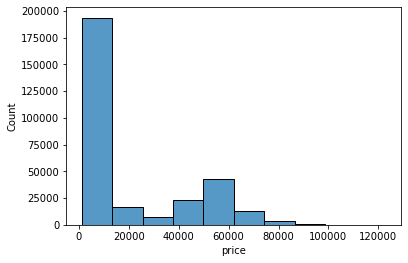

In [146]:
sns.histplot(data = dataset['price'], bins=10)

#### Relação airline-bilhetes

ValueError: cannot set using a list-like indexer with a different length than the value

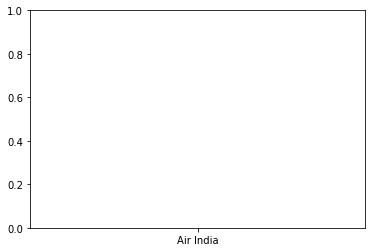

In [147]:
sns.histplot(data=dataset, x="airline", hue="business", multiple="dodge")


É possivel verificar que as companhias Vistara e AirIndia têm os preços com a maior variação e os voos mais caros

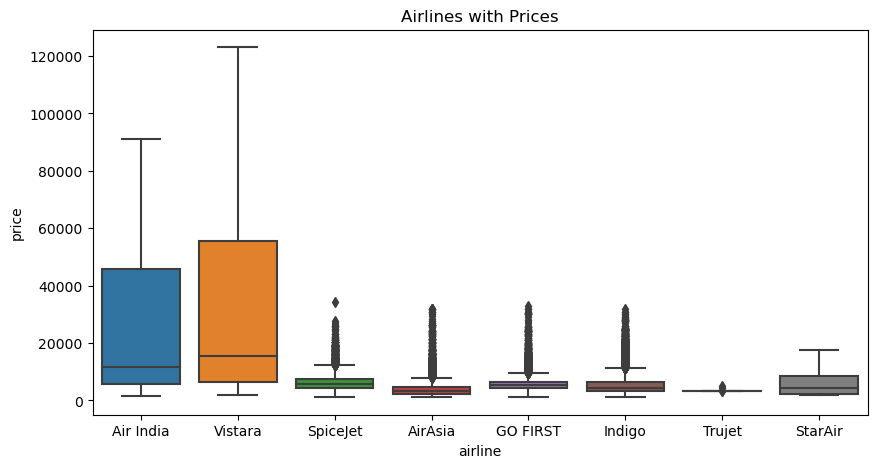

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data=dataset, x="airline", y="price")
plt.title("Airlines with Prices")
plt.show()

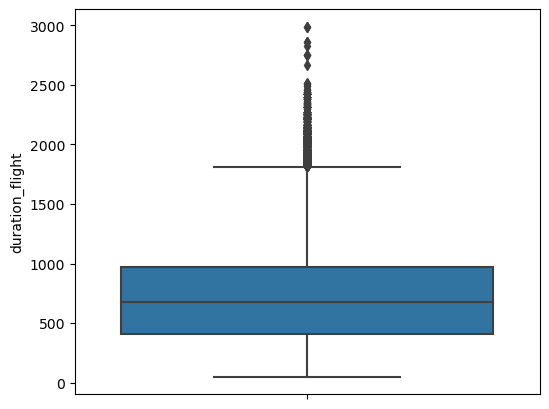

In [ ]:
plt.figure(figsize = (6,5))
sns.boxplot(data=dataset, y="duration_flight")
plt.show()

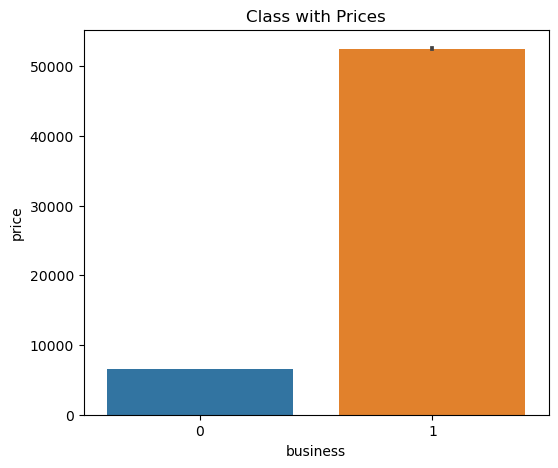

In [ ]:
plt.figure(figsize = (6,5))
sns.barplot(data=dataset, x="business", y="price")
plt.title("Class with Prices")
plt.show()

#### Analise do preço dos bilhetes

Text(0.5, 1.0, 'Airline prices based on the class and company')

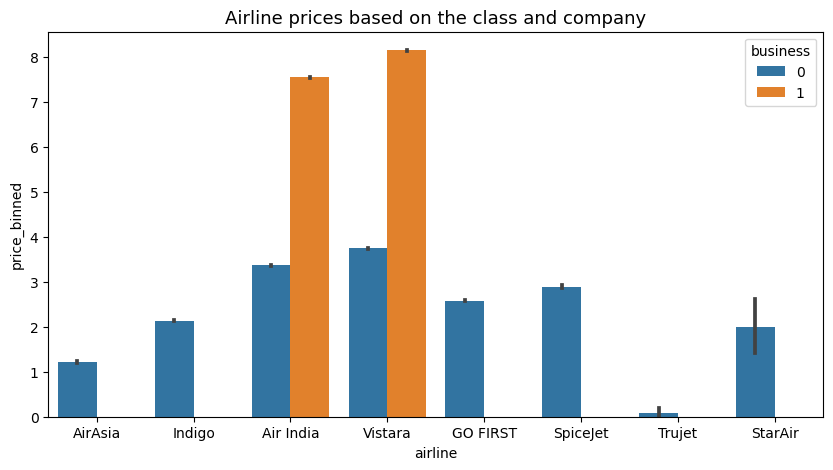

In [ ]:
plt.figure(figsize = (10,5))
estimator = preprocessing.KBinsDiscretizer(n_bins=10, encode="ordinal", strategy='quantile') # testar com onehot encoding
dataset['price_binned'] = estimator.fit_transform(dataset[['price']])
# print(estimator.bin_edges_[0])
dataset.groupby(by=['price_binned']).count()

sns.barplot(x='airline',y='price_binned',hue="business",data=dataset.sort_values("price_binned")).set_title('Airline prices based on the class and company',fontsize=13)

### Preço a semana e ao fim de semana

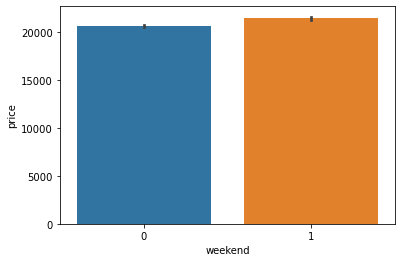

In [ ]:
sns.barplot(data=dataset, x="weekend", y="price")

#como este atributo não tem grande variação obptamos por fazer o drop

dataset = dataset.drop(['weekend'], axis=1)

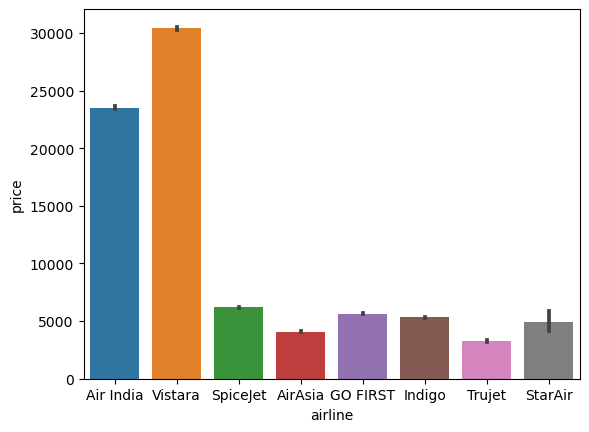

In [ ]:

sns.barplot(data=dataset, x="airline", y="price")



### Label Encoding 

In [ ]:
dataset.to_csv('before.csv')

label_encoder = preprocessing.LabelEncoder()
label_encoder.inverse_transform

dataset['airline'] = label_encoder.fit_transform(dataset['airline'])
dataset['character_code'] = label_encoder.fit_transform(dataset['character_code'])
dataset['source_city'] = label_encoder.fit_transform(dataset['source_city'])
dataset['destination_city'] = label_encoder.fit_transform(dataset['destination_city'])
 


#### Searching for missing values

In [ ]:

print(dataset.isnull().sum())

dataset = dataset.dropna()

print(dataset.isnull().sum())

airline             0
character_code      0
numerical_code      0
source_city         0
duration_flight     0
stops               0
destination_city    0
price               0
business            0
year                0
month               0
day                 0
departure_hour      0
departure_min       0
arrival_hour        0
arrival_min         0
price_binned        0
dtype: int64
airline             0
character_code      0
numerical_code      0
source_city         0
duration_flight     0
stops               0
destination_city    0
price               0
business            0
year                0
month               0
day                 0
departure_hour      0
departure_min       0
arrival_hour        0
arrival_min         0
price_binned        0
dtype: int64


### Correlation Matrix

year
2022    300255
Name: year, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300255 entries, 0 to 206773
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300255 non-null  int64  
 1   character_code    300255 non-null  int64  
 2   numerical_code    300255 non-null  int64  
 3   source_city       300255 non-null  int64  
 4   duration_flight   300255 non-null  int64  
 5   stops             300255 non-null  int64  
 6   destination_city  300255 non-null  int64  
 7   price             300255 non-null  int64  
 8   business          300255 non-null  int64  
 9   month             300255 non-null  int64  
 10  day               300255 non-null  int64  
 11  departure_hour    300255 non-null  int64  
 12  departure_min     300255 non-null  int64  
 13  arrival_hour      300255 non-null  int64  
 14  arrival_min       300255 non-null  int64  
 15  price_binned      30025

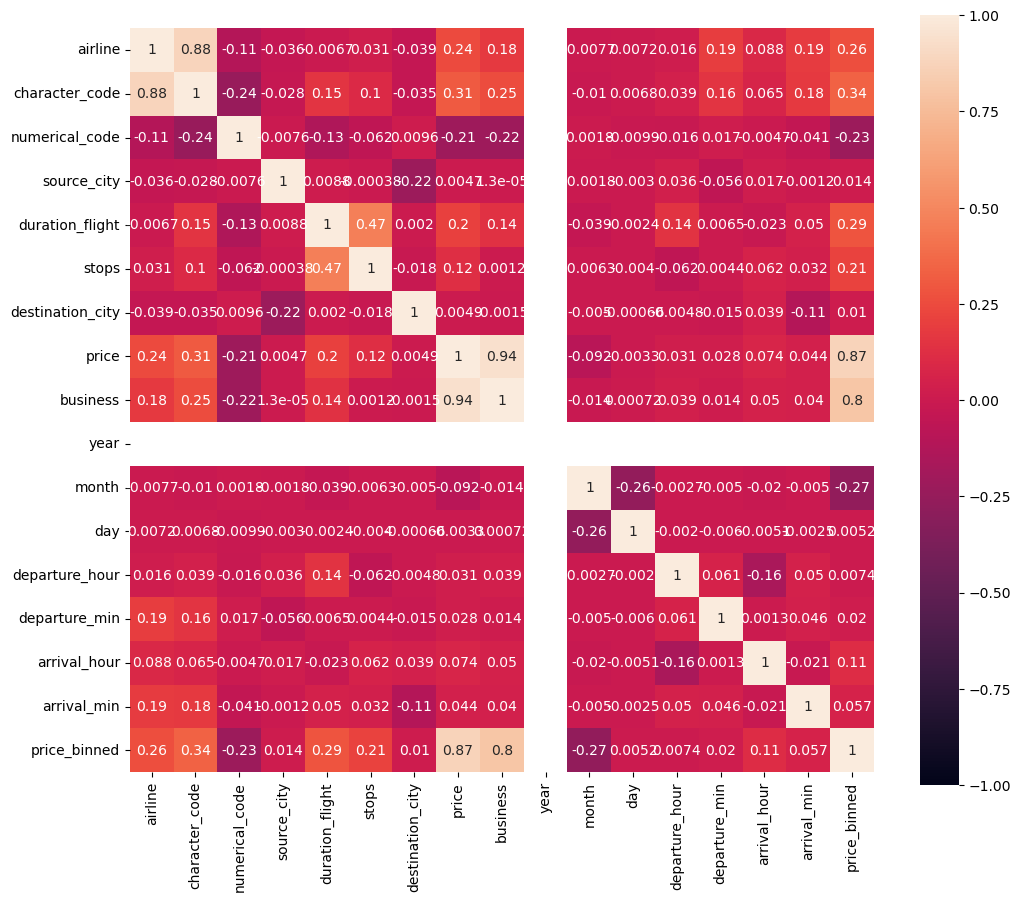

In [ ]:

corr_matrix = dataset.corr()
f , ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, square=True, annot=True)

yearValues1 = dataset.groupby(['year'])['year'].count()
print(yearValues1)

#remove data 
dataset = dataset.drop(['year'], axis=1)
dataset.info()


# Model


In [ ]:
X = dataset.drop(['price','price_binned'], axis=1)
y = dataset['price'].to_frame()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2022)


#### Decision Tree Classifier

In [ ]:

dTree_clf = DecisionTreeRegressor(random_state=2022)
dTree_clf.fit(X_train,y_train)

y_pred = dTree_clf.predict(X_test)


print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))



R^2 :  0.9850573621862233
MAE : 840.055924686239


### Random Forest Regression

In [ ]:

# Perform Grid-Search
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='r2', verbose=0, n_jobs=-1)
    
grid_result = gsc.fit(X, y.values.ravel())
best_params = grid_result.best_params_

print(best_params)

rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)
# Perform K-Fold CV
scores = cross_val_score(rfr, X, y, cv=10, scoring='r2')


NameError: name 'X' is not defined

#### XGBoost

In [ ]:


model = xgb.XGBRegressor(max_depth = 11, eta = 0.4)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=2022)
# evaluate model
scores = cross_val_score(model, X, y, scoring='r2', cv=cv)

print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))






NameError: name 'X_train' is not defined